## Part - 3 

In this part of our project review, we trained the following three classification models by tuning different hyperparameters- 
- Extreme Learning Machine
- SVM with polynomial kernal
- Deep Learning / Multi-layer Perceptron

In [1]:
# Importing all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# from skelm import ELMClassifier as elm
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading the cleaned dataset

group_16_df = pd.read_csv('Group_16_data_cleaned.csv')
group_16_df.head()

,Unnamed: 0,Subject,Hold .,Hold t,Hold i,Hold e,Hold Shift,Hold 5,Hold Shift.1,Hold Caps,...,Size Caps,Size r,Size o,Size a,Size n,Size l,Size Enter,AvH,AvP,AvA
0,0,1.0,106.0,92.0,111.0,85.0,123.0,82.0,70.0,101.00,...,0.225806,0.225806,0.322581,0.290323,0.225806,0.354839,0.274194,103.035714,0.190971,0.288018
1,1,1.0,106.0,88.0,111.0,83.0,123.0,101.0,81.0,94.00,...,0.225806,0.225806,0.322581,0.322581,0.258065,0.387097,0.322581,103.035714,0.186514,0.285138
2,2,1.0,106.0,90.0,111.0,65.0,79.0,73.0,96.0,63.25,...,0.225806,0.193548,0.290323,0.322581,0.225806,0.258065,0.274194,103.035714,0.186171,0.285138
3,3,1.0,106.0,81.0,111.0,72.0,83.0,94.0,89.0,104.00,...,0.225806,0.225806,0.258065,0.290323,0.225806,0.322581,0.322581,103.035714,0.177943,0.285138
4,4,1.0,106.0,72.0,111.0,82.0,62.0,89.0,68.0,88.00,...,0.290323,0.225806,0.322581,0.258065,0.225806,0.290323,0.387097,103.035714,0.163971,0.285138


In [3]:
# extracting and assigning the input and output variables from the dataset

x, y = group_16_df.iloc[:, 2:].values, group_16_df['Subject'].values
x.shape, y.shape

((2856, 71), (2856,))

In [4]:
# splitting the imported dataset as train(70%) and test(30%) sets.

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.3, random_state = 222)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1999, 71) (1999,)
(857, 71) (857,)


In [5]:
# Standard scaler is used to scale all the features to have equal weightage

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

## Extreme Learning Machine

In [6]:
# Define a class for GridSearchCV on ELM:

from skelm import ELMClassifier
from itertools import product

class ELMGridSearch:
    
    def __init__(self, param_grid, cv=5):
        self.param_grid = param_grid
        self.cv = cv
        
    def fit(self, x_train, y_train):
        best_score = 0
        best_params = None
        n_samples = x_train.shape[0]
        fold_size = n_samples // self.cv
        
        for params in product(*self.param_grid.values()):
            params = dict(zip(self.param_grid.keys(), params))
            clf = ELMClassifier(**params)
            clf.fit(x_train, y_train)
            
            # Perform manual cross-validation
            scores = []
            for fold in range(self.cv):
                start = fold * fold_size
                end = start + fold_size
                # Split data into training and validation folds
                x_val = x_train[start:end]
                y_val = y_train[start:end]
                x_tr = np.concatenate((x_train[:start], x_train[end:]))
                y_tr = np.concatenate((y_train[:start], y_train[end:]))
                # Train the model on the training fold
                clf.fit(x_tr, y_tr)
                # Evaluate the model on the validation fold
                score = clf.score(x_val, y_val)
                scores.append(score)
                
            # Compute the average performance across all folds
            score = np.mean(scores)
            if score > best_score:
                best_score = score
                best_params = params
        self.best_params_ = best_params
        self.best_score_ = best_score
        self.best_estimator_ = ELMClassifier(**best_params)
        self.best_estimator_.fit(x_train, y_train)
        self.CV_scores = scores
        return self
    
    def predict(self, x_test):
        return self.best_estimator_.predict(x_test)


In [7]:
# defining the parameters grid and fitting the model

param_grid = {'n_neurons' : range(100, 1000, 50),
                'ufunc': ['relu', 'tanh'],
                'random_state' : [222],
                'alpha' : np.arange(0.0001, 0.01, 0.001)}

model1 = ELMGridSearch(param_grid, cv=5)
model1.fit(x_train, y_train)

In [8]:
# optimum hyperparameters

model1.best_score_, model1.best_params_, model1.CV_scores

(0.8551378446115289,
 {'n_neurons': 500, 'ufunc': 'relu', 'random_state': 222, 'alpha': 0.0001},
 [0.7518796992481203,
  0.8295739348370927,
  0.8170426065162907,
  0.8295739348370927,
  0.7794486215538847])

In [9]:
# train & test accuracies 

y_pred_train = model1.predict(x_train)
y_pred_test = model1.predict(x_test)

train_score = accuracy_score(y_pred_train, y_train)
print("score on train data: ", train_score)
test_score = accuracy_score(y_pred_test, y_test)
print("score on test data: ", test_score)

score on train data:  0.992496248124062
score on test data:  0.8623103850641773


              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         9
         2.0       0.94      0.94      0.94        17
         3.0       1.00      0.79      0.88        14
         4.0       0.90      1.00      0.95        18
         5.0       0.80      0.75      0.77        16
         6.0       1.00      0.93      0.97        15
         7.0       0.88      1.00      0.94        15
         8.0       1.00      0.83      0.90        23
         9.0       0.53      0.73      0.62        11
        10.0       0.80      0.75      0.77        16
        11.0       1.00      0.87      0.93        15
        12.0       0.94      1.00      0.97        16
        13.0       0.92      0.92      0.92        13
        14.0       0.82      0.82      0.82        17
        15.0       1.00      1.00      1.00        17
        16.0       0.80      0.80      0.80        15
        17.0       0.78      1.00      0.88        14
        18.0       0.94    

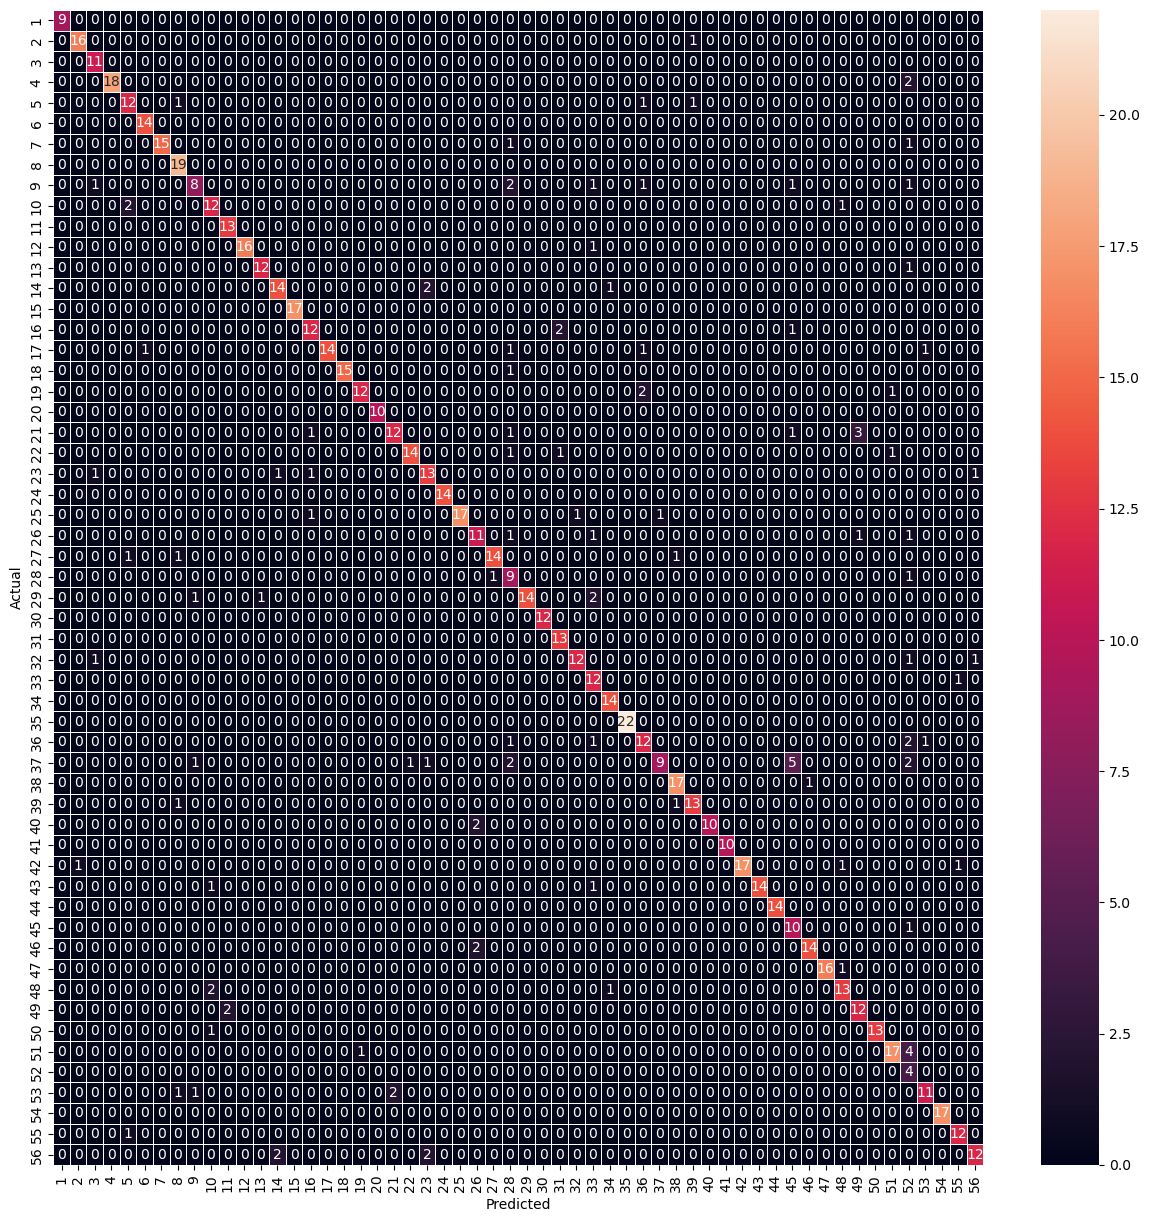

In [10]:
# Confusion matrix 

cm = confusion_matrix(y_pred_test, y_test)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax, 
            xticklabels = list(range(1,57)),
            yticklabels = list(range(1,57)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Classification report

print(classification_report(y_test, y_pred_test))

## SVM non-linear

> folds = 2, accuracy = 0.884 with std = 0.002
> folds = 3, accuracy = 0.912 with std = 0.023
> folds = 4, accuracy = 0.917 with std = 0.016
> folds = 5, accuracy = 0.922 with std = 0.012
> folds = 6, accuracy = 0.923 with std = 0.020
> folds = 7, accuracy = 0.928 with std = 0.016
> folds = 8, accuracy = 0.931 with std = 0.018
> folds = 9, accuracy = 0.926 with std = 0.020
> folds = 10, accuracy = 0.930 with std = 0.019


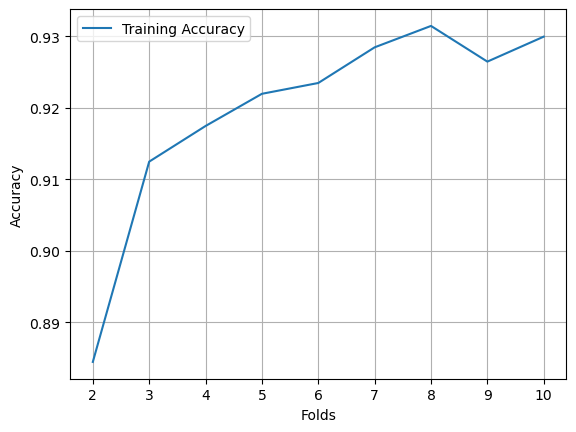

In [11]:
# k-fold cross validation

from numpy import mean
from numpy import std
from sklearn.model_selection import KFold

ax = list(range(2, 11))
ay = []

# finding the best K value for K-fold cross validation
for n in ax:
    cv = KFold(n_splits = n)
    scores = cross_val_score(SVC(), x_train, y_train, scoring='accuracy', cv = cv, n_jobs =-1)
    ay.append(mean(scores))
    print('> folds = %d, accuracy = %.3f with std = %.3f' % (n, mean(scores), std(scores)))
    
plt.plot(ax, ay, label = 'Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Folds')
plt.xticks(ax)
plt.legend()
plt.grid()

In [12]:
# using grid search to find the optimal hyperparameters

model2 = GridSearchCV(estimator = SVC(),
                  param_grid = {'C' : [0.1, 1, 10, 50, 100],
                                'degree' : range(2, 5),
                                'kernel' : ['poly'],
                                'random_state' : [222]}, 
                  cv = 5, scoring = "accuracy")

model2.fit(x_train, y_train)

model2.best_score_, model2.best_params_

(0.8799398496240602,
 {'C': 50, 'degree': 2, 'kernel': 'poly', 'random_state': 222})

In [13]:
# train & test accuracies 

y_pred_train = model2.predict(x_train)
y_pred_test = model2.predict(x_test)

train_score = accuracy_score(y_pred_train, y_train)
print("score on train data: ", train_score)
test_score = accuracy_score(y_pred_test, y_test)
print("score on test data: ", test_score)

score on train data:  1.0
score on test data:  0.8798133022170361


              precision    recall  f1-score   support

         1.0       1.00      0.78      0.88         9
         2.0       0.80      0.94      0.86        17
         3.0       0.80      0.86      0.83        14
         4.0       0.94      0.94      0.94        18
         5.0       1.00      0.69      0.81        16
         6.0       0.88      1.00      0.94        15
         7.0       0.93      0.93      0.93        15
         8.0       1.00      0.91      0.95        23
         9.0       0.64      0.82      0.72        11
        10.0       0.92      0.75      0.83        16
        11.0       1.00      0.80      0.89        15
        12.0       1.00      1.00      1.00        16
        13.0       0.92      0.92      0.92        13
        14.0       0.79      0.88      0.83        17
        15.0       1.00      0.76      0.87        17
        16.0       0.67      0.80      0.73        15
        17.0       0.74      1.00      0.85        14
        18.0       0.83    

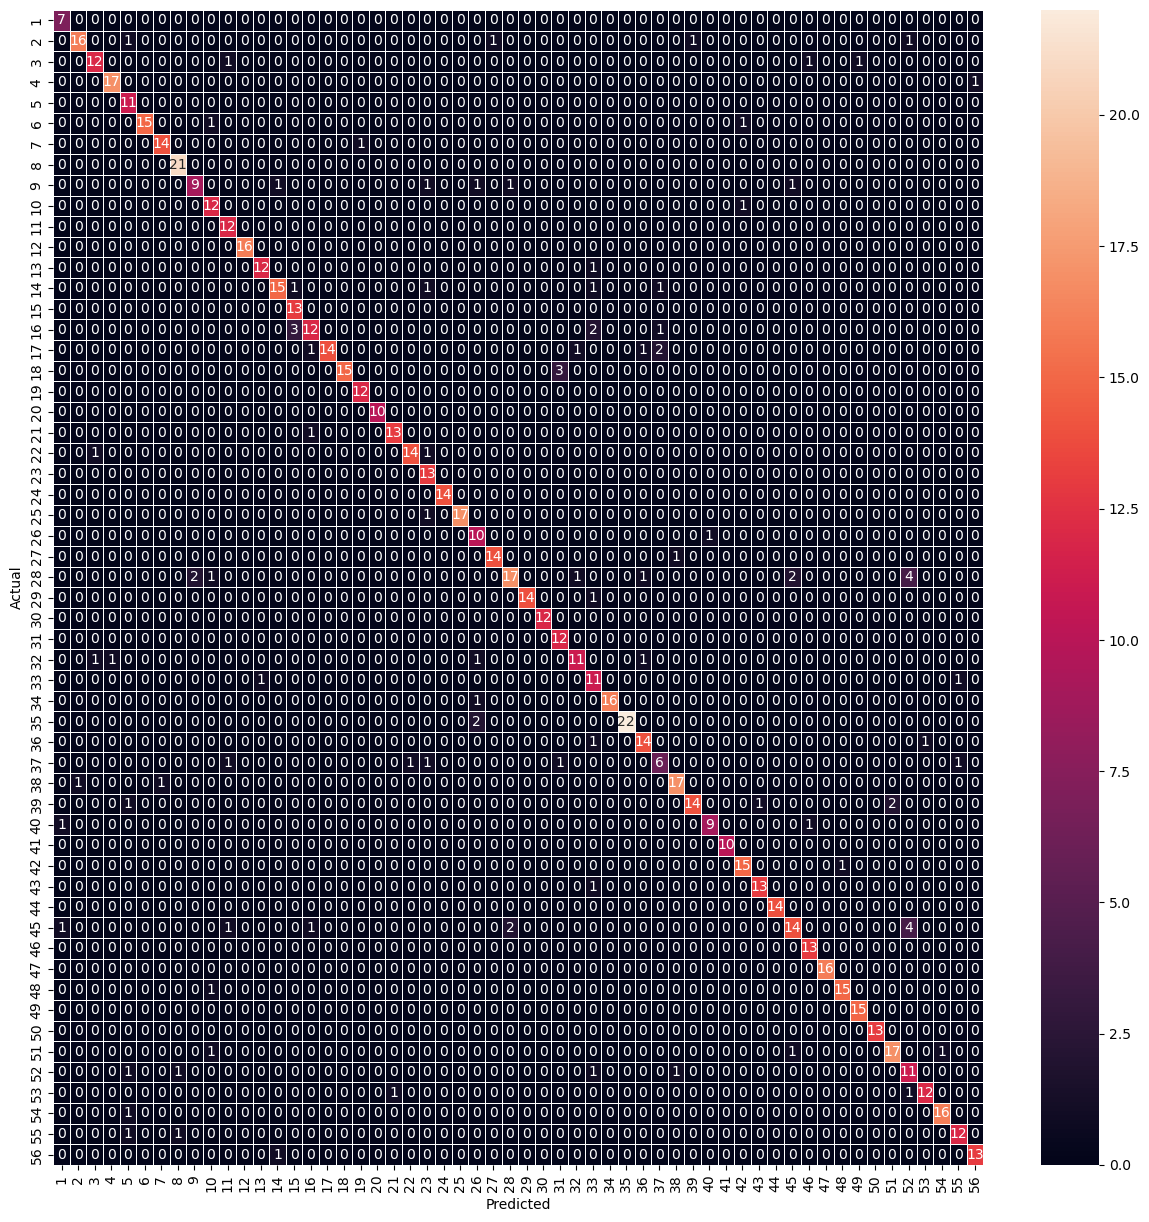

In [14]:
# Confusion matrix 

cm = confusion_matrix(y_pred_test, y_test)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax, 
            xticklabels = list(range(1,57)),
            yticklabels = list(range(1,57)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Classification report

print(classification_report(y_test, y_pred_test))

## Deep Learning

> folds = 2, accuracy = 0.881 with std = 0.003
> folds = 3, accuracy = 0.895 with std = 0.010
> folds = 4, accuracy = 0.907 with std = 0.014
> folds = 5, accuracy = 0.906 with std = 0.016
> folds = 6, accuracy = 0.907 with std = 0.009
> folds = 7, accuracy = 0.912 with std = 0.011
> folds = 8, accuracy = 0.912 with std = 0.020
> folds = 9, accuracy = 0.910 with std = 0.020
> folds = 10, accuracy = 0.912 with std = 0.024


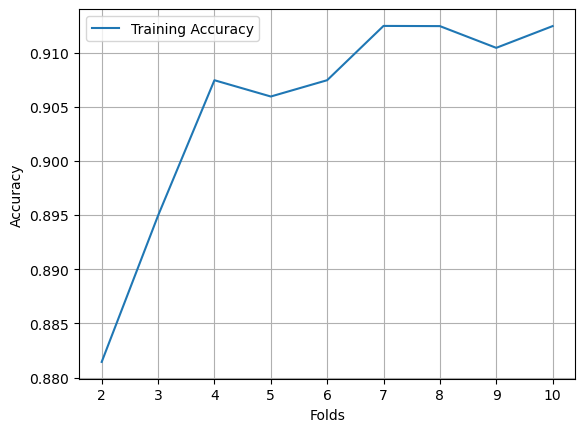

In [15]:
# k-fold cross validation

ax = list(range(2, 11))
ay = []

# finding the best K value for K-fold cross validation
for n in ax:
    cv = KFold(n_splits = n)
    scores = cross_val_score(MLPClassifier(), x_train, y_train, scoring='accuracy', cv = cv, n_jobs =-1)
    ay.append(mean(scores))
    print('> folds = %d, accuracy = %.3f with std = %.3f' % (n, mean(scores), std(scores)))
    
plt.plot(ax, ay, label = 'Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Folds')
plt.xticks(ax)
plt.legend()
plt.grid()

In [16]:
# using grid search to find the optimal hyperparameters

param_grid = {'hidden_layer_sizes': [(100,), (200,), (500,), (1000,)],
                'activation': ['relu', 'logistic', 'tanh'],
                'solver': ['adam', 'sgd'],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate': ['constant', 'adaptive'],
                'random_state' : [222]}

model3 = RandomizedSearchCV(MLPClassifier(), param_grid)
model3.fit(x_train, y_train)
model3.best_score_, model3.best_params_

(0.9239611528822056,
 {'solver': 'adam',
  'random_state': 222,
  'learning_rate': 'constant',
  'hidden_layer_sizes': (1000,),
  'alpha': 0.0001,
  'activation': 'logistic'})

In [17]:
# train & test accuracies 

y_pred_train = model3.predict(x_train)
y_pred_test = model3.predict(x_test)

train_score = accuracy_score(y_pred_train, y_train)
print("score on train data: ", train_score)
test_score = accuracy_score(y_pred_test, y_test)
print("score on test data: ", test_score)

score on train data:  1.0
score on test data:  0.9393232205367561


              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         9
         2.0       0.94      1.00      0.97        17
         3.0       1.00      1.00      1.00        14
         4.0       1.00      0.94      0.97        18
         5.0       1.00      0.94      0.97        16
         6.0       0.94      1.00      0.97        15
         7.0       1.00      1.00      1.00        15
         8.0       1.00      0.96      0.98        23
         9.0       0.82      0.82      0.82        11
        10.0       1.00      0.81      0.90        16
        11.0       1.00      1.00      1.00        15
        12.0       0.94      1.00      0.97        16
        13.0       1.00      1.00      1.00        13
        14.0       0.83      0.88      0.86        17
        15.0       0.94      1.00      0.97        17
        16.0       0.87      0.87      0.87        15
        17.0       0.78      1.00      0.88        14
        18.0       0.88    

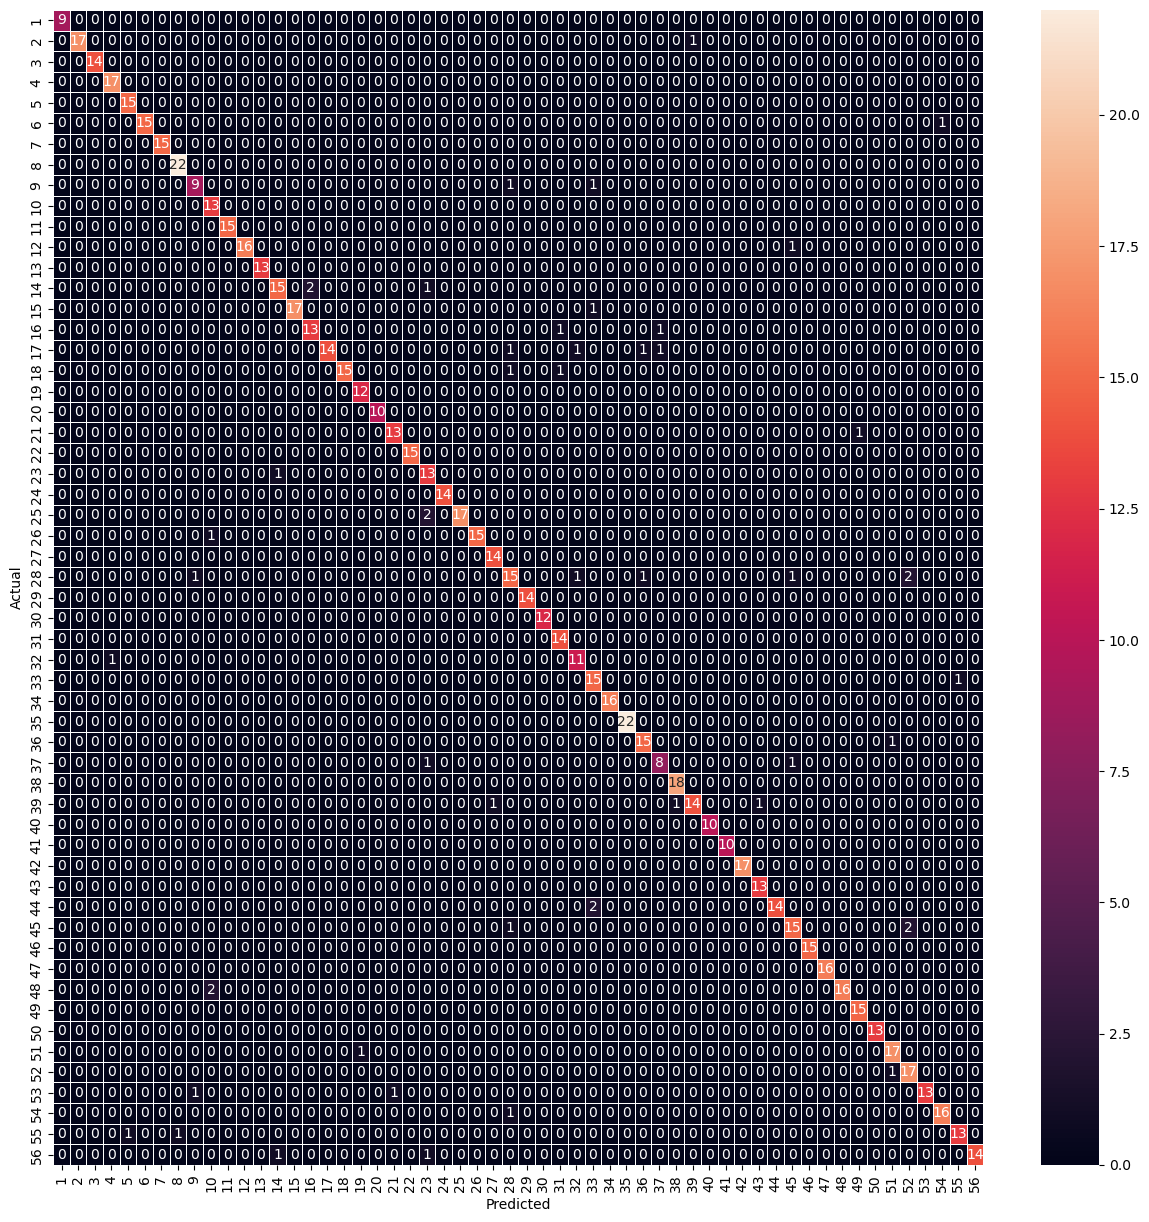

In [18]:
# Confusion matrix 

cm = confusion_matrix(y_pred_test, y_test)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax, 
            xticklabels = list(range(1,57)),
            yticklabels = list(range(1,57)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Classification report

print(classification_report(y_test, y_pred_test))


- Extreme Learning Machine - score on test data: 86.231%
- SVM with polynomial kernal - score on test data: 87.981%
- Deep Learning / Multi-layer Perceptron - score on test data: 93.932% 
